# Building the Image Classifier

This project uses transfer learning to build an image classifier for 102 flower species. The data comes from [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) containing 102 flower categories.

This notebook will serve as the beginning test implementation for the image classifier.

In [1]:
# Import required packages
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

## Load the data

Data is loaded using `torchvision` ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data can be [downloaded it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts: training, validation, and testing.

For the training, tranformations such as random scaling, flipping, cropping are applied to help the network improve generalization capibilities for better performance. Note that the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. These datasets will not have any scaling or rotation transformations applied, but they are resized and cropped to the appropriate size.

Because the pre-trained networks were trained on the ImageNet dataset where each color channel was normalized separately, we need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [5]:
# Set data directories
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [6]:
# Define transformations for the training, validation, and testing sets
shared_transforms = [transforms.ToTensor(),
                     transforms.Normalize([0.485, 0.456, 0.406],
                                          [0.229, 0.224, 0.225])]

data_transforms = {
    'training': transforms.Compose(
        [transforms.RandomRotation(30),
         transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip()] + 
         shared_transforms),
    'nontraining': transforms.Compose(
        [transforms.Resize(250),
         transforms.CenterCrop(224)] + 
         shared_transforms)
}

# Load the datasets with ImageFolder
image_datasets = {
    'training': datasets.ImageFolder(train_dir, transform=data_transforms['training']),
    'validation': datasets.ImageFolder(valid_dir, data_transforms['nontraining']),
    'test': datasets.ImageFolder(test_dir, data_transforms['nontraining'])
}

# Define dataloaders iusing the image datasets and the transforms
training_loader = torch.utils.data.DataLoader(image_datasets['training'], batch_size=64)
validation_loader = torch.utils.data.DataLoader(image_datasets['validation'], batch_size=64)
test_loader = torch.utils.data.DataLoader(image_datasets['test'], batch_size=64)

### Label mapping

Because the datasets are separated into numbered category folders, we also need to load a JSON file that maps the numerical category labels to the actual category name (flower species). The mapping is located in the file `cat_to_name.json` and is read in with the [`json` module](https://docs.python.org/2/library/json.html). This will provide us with a dictionary mapping the numerical categories to the actual names of the flowers.

In [2]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

## Sample:
# {'21': 'fire lily',
#  '3': 'canterbury bells',
#  ...
# }

# Building and training the classifier

We will use a pre-trained model from `torchvision.models` to get the image features. Next, we will build and train a new feed-forward classifier using those features with the following process:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html). This notebook uses VGG-11.
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout.
* Train the classifier layers using backpropagation using the pre-trained network to get the features.
* Track the loss and accuracy on the validation set to determine the best hyperparameters.

In [3]:
# Use GPU if available, if not use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# Use the VGG11 model for transfer learning
model = models.vgg11(pretrained=True)

# Make sure parameters are frozen
for param in model.parameters():
    param.requires_grad = False
    
# See model details below
model

Downloading: "https://download.pytorch.org/models/vgg11-bbd30ac9.pth" to /Users/morinoko/.cache/torch/checkpoints/vgg11-bbd30ac9.pth
100.0%


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [21]:
# Build a new, untrained classifier which will be trained on our flower images

class Classifier(nn.Module):
    def __init__(self, inputs, hidden, outputs):
        super().__init__()
        
        self.fc1 = nn.Linear(inputs, hidden)
        self.output = nn.Linear(hidden, outputs)
        
        # Add dropout rate with 50% probability
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        # make sure input is flattened
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        
        # No dropout for output layer, return log softmax of output
        return F.log_softmax(self.output(x), dim=1)
    
    def learn(self, device, model, training_loader, validation_loader, criterion, epochs=30, print_every=100):
        running_loss = 0
        steps = 0
        
        for epoch in range(epochs):
            for images, labels in training_loader:
                steps += 1

                images, labels = images.to(device), labels.to(device)

                # Reset gradients
                optimizer.zero_grad()

                # Forward pass
                log_prob = model.forward(images)
                loss = criterion(log_prob, labels)
                # Backward pass
                loss.backward()
                optimizer.step()

                running_loss += loss
                
                if steps % print_every == 0:
                    # Switch to evaluation mode
                    model.eval()
                    
                    validation_loss, accuracy = model.classifier.validation(device, model, validation_loader, criterion)
                    
                    print('Epoch: {}/{}..'.format(epoch+1, epochs),
                          'Training loss: {:.3f}.. '.format(running_loss/print_every),
                          'Validation loss: {:.3f}..'.format(validation_loss),
                          'Accuracy: {:.3f}%'.format((accuracy*100)))
                    
                    # Switch back to training mode
                    model.train()
                    # Reset running loss
                    running_loss = 0
                    
    def validation(self, device, model, validation_loader, criterion):
        validation_loss = 0
        accuracy = 0
        
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            with torch.no_grad():
                # Calculate log probabilities and loss
                log_prob = model.forward(images)
                loss = criterion(log_prob, labels)
                validation_loss += loss

                # Calculate accuracy
                prob = torch.exp(log_prob)
                top_p, top_class = prob.topk(1, dim=1)
                equalities = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equalities.type(torch.FloatTensor)).item()
        
        validation_loss = validation_loss/len(validation_loader)
        accuracy = accuracy/len(validation_loader)
        
        return validation_loss, accuracy

In [36]:
# Set up classifier model
inputs = 25088
hidden = 512
outputs = 102

classifier = Classifier(inputs, hidden, outputs)

# Set the VGG classifier to be the new, untrained classifier
model.classifier = classifier

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.classifier.parameters(), lr=0.001)

In [37]:
# Train network
model.to(device)

model.classifier.learn(device, model, training_loader, validation_loader, criterion)

Epoch: 1/30.. Training loss: 4.682..  Validation loss: 4.456.. Accuracy: 8.067%
Epoch: 2/30.. Training loss: 4.521..  Validation loss: 4.291.. Accuracy: 12.274%
Epoch: 3/30.. Training loss: 4.418..  Validation loss: 4.119.. Accuracy: 11.779%
Epoch: 4/30.. Training loss: 4.279..  Validation loss: 3.926.. Accuracy: 15.899%
Epoch: 5/30.. Training loss: 4.169..  Validation loss: 3.743.. Accuracy: 19.058%
Epoch: 6/30.. Training loss: 4.017..  Validation loss: 3.565.. Accuracy: 23.264%
Epoch: 7/30.. Training loss: 3.866..  Validation loss: 3.383.. Accuracy: 28.106%
Epoch: 8/30.. Training loss: 3.778..  Validation loss: 3.199.. Accuracy: 35.692%
Epoch: 9/30.. Training loss: 3.629..  Validation loss: 3.036.. Accuracy: 36.808%
Epoch: 10/30.. Training loss: 3.524..  Validation loss: 2.880.. Accuracy: 39.572%
Epoch: 11/30.. Training loss: 3.412..  Validation loss: 2.721.. Accuracy: 44.380%
Epoch: 12/30.. Training loss: 3.265..  Validation loss: 2.592.. Accuracy: 44.928%
Epoch: 13/30.. Training lo

## Testing the network

Next, to get a good estimate of the model's performance, the trained network will be tested on test data, which are images the network has never seen either in training or validation.

In [49]:
# Do validation on the test set
model.eval()

accuracy = 0
epochs = 1

for epoch in range(epochs):
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            log_prob = model.forward(images)

            # Calculate accuracy
            prob = torch.exp(log_prob)
            top_p, top_class = prob.topk(1, dim=1)
            equalities = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equalities.type(torch.FloatTensor)).item()

print("Accuracy: {:.3f}%".format((accuracy/len(test_loader))*100))

Accuracy: 74.093%


## Saving the checkpoint

After the network is trained, we want to save the model so we can load it later for making predictions. Below we will save the hyperparameters (inputs, outputs, hidden inputs) and state dictionary. It also includes a mapping of classes to indices (available from one of the image datasets: `image_datasets['train'].class_to_idx`) so we can attach it to the model as an attribute later on like so:

```model.class_to_idx = image_datasets['train'].class_to_idx```

The model will be completely rebuilt later so we can use it for inference (For continued training, make sure to also save the number of epochs as well as the optimizer state with `optimizer.state_dict`).

In [39]:
# Save the checkpoint 
checkpoint = {
    'input_size': 25088,
    'output_size': 102,
    'hidden_input': 512,
    'classifier_state_dict': model.classifier.state_dict(),
    'class_to_idx': image_datasets['training'].class_to_idx
}

torch.save(checkpoint, 'checkpoint.pth')

## Loading the checkpoint

The function below will load a checkpoint and rebuild the model so we can keep working on it without having to retrain the network.

In [8]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    
    model = models.vgg11(pretrained=True)

    # Make sure parameters are frozen
    for param in model.parameters():
        param.requires_grad = False
    
    classifier = Classifier(checkpoint['input_size'], checkpoint['hidden_input'], checkpoint['output_size'])
    model.classifier = classifier
    
    model.classifier.load_state_dict(checkpoint['classifier_state_dict'])
    model.class_to_idx = checkpoint['class_to_idx'] 
    
    return model


# Inference for classification

Below we'll prepare a function that allows us to use a trained network for inference. It will let us pass an image and a model into the network and predict the top most likely classes of the flower along with the probabilities (return as lists).

First off, we need to process the input image such that it can be used in the network. 

## Image Preprocessing

We'll be using `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)) and process it in the same manner used for training.

* Resize the images where the shortest side is 256 pixels, keeping the aspect ratio (use [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail)).
* Crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expects floats 0-1, so we need to convert the values. This can be easily done by converting the PIL image to a Numpy array: `np_image = np.array(pil_image)`.

Again, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. To normalize, we will subtract the means from each color channel, then divide by the standard deviation. 

Finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. We will reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). (The color channel needs to be first and retain the order of the other two dimensions.)

In [9]:
def thumbnail_image(image, new_shortest_side):
    """Returns thumbnail of image resized so that the 
       shortest side is resized to the given size, keeping the aspect ration
    
        Args:
            image = image object
            new_shortest_side = desired size of the shortest size in pixels
    """
    size = np.array(image.size)
    shortest_side = size.min()
    aspect_ratio = new_shortest_side/size.min()
    
    return image.resize(np.array(np.floor(size * aspect_ratio), dtype='int'))

def square_center_crop(image, square_size):
    """Returns image cropped to the square of desired size
    Args:
    image = image object
    square_size = size in pixels
    """
    width, height = image.size
    
    # Crop box coords
    left = (width - square_size)//2
    top = (height- square_size)//2
    right = left + square_size
    bottom = top + square_size
    
    return image.crop((left, top, right, bottom))
    
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Tensor
    '''
    # Process a PIL image for use in a PyTorch model
    image = Image.open(image)
    thumb = thumbnail_image(image, 256)
    cropped_image = square_center_crop(thumb, 224)
    
    # Convert image to numpy array of floats
    np_image = np.array(cropped_image)
    
    # Normalize values by dividing by subracting means [0.485, 0.456, 0.406]
    # and dividing by std. dev. [0.229, 0.224, 0.225]
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    normalized_image = (np_image/255 - mean)/std # divide by 255 or the colors turn out weird
    
    # move color channel to first position in array and convert to tensor
    return torch.Tensor(normalized_image.transpose((2, 0, 1)))

The function below lets us check our work above by converting a PyTorch tensor and displaying it in the notebook. If the `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

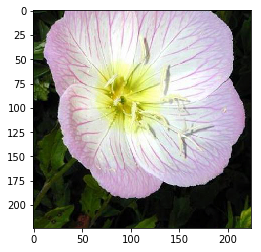

In [10]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    if title:
        ax.set_title(title)
        
    return ax

image = process_image('flowers/test/1/image_06743.jpg')
imshow(image);

## Class Prediction

Once the images are preprocessed, we can make predictions with the model. We will predict the top 5 most probable classes by calculating the class probabilities then finding the $K$ largest values with [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk).

`.topk()` returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes, so we'll convert the indices to the actual class labels using `class_to_idx` which was added to the model when loaded.

Again, the prediction method will take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [22]:
def predict(image_path, model_checkpoint_path, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    Return a list of topk probabilities and the classes they belong to
    '''
    model = load_checkpoint(model_checkpoint_path)
    model.eval()
    
    image = process_image(image_path)
    # Add 'batch' parameter of 1 to image tensor needed by the model
    # Image size becomes [1, 3, 224, 224]
    image = image.unsqueeze(0)
    
    probabilities = torch.exp(model(image))
    probs, class_indices = [tensor.tolist()[0] for tensor in probabilities.topk(5, dim=1)]
    
    # Map class indices to class labels (image folders)
    class_dict = model.class_to_idx
    class_list = list(class_dict.keys())
    index_list = list(class_dict.values())

    class_list = [class_list[index_list.index(idx)] for idx in class_indices]
    
    return probs, class_list

## Sanity Checking

This checks to make sure the predictions from the trained model make sense and that there aren't any obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image.

Here, we'll use matplotlib to plot the image and bar graph of probabilities and use the category mapping JSON file to convert the numerical categories into actual flower names.

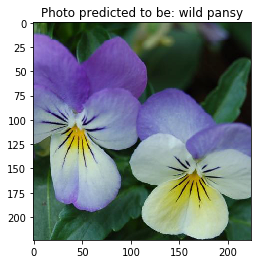

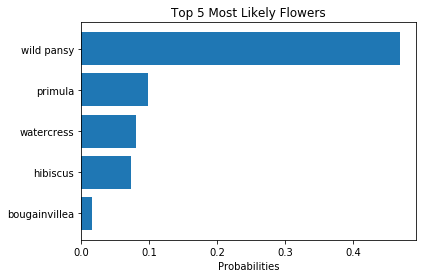

In [29]:
# Display an image along with the top 5 classes
test_image = 'flowers/test/52/image_04160.jpg'
probs, classes = predict(test_image, 'checkpoint.pth')
# Convert class numbers to flower names
flower_labels = [cat_to_name[flower_class] for flower_class in classes]

imshow(process_image(test_image), 
       title=("Photo predicted to be: " + flower_labels[0]))

fig, ax = plt.subplots()
y_coords = np.arange(5)
ax.barh(y_coords, probs[::-1], tick_label=flower_labels[::-1])
ax.set_xlabel('Probabilities')
ax.set_title("Top 5 Most Likely Flowers");

In [24]:
print(probs)

[0.4689990282058716, 0.09815101325511932, 0.08019277453422546, 0.07368869334459305, 0.015866994857788086]
